In [1]:
#6000 TRAIN, 4000 TEST
#no signal (0) BLUE , electron/positron (1) GREEN , another kind of particles (2) YELLOW

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

import csv
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn.model_selection
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


from mpl_toolkits.mplot3d import Axes3D
import tables

from tqdm import trange

train_file = 'train.hdf5'
#test_file = 'dataset/test_1-2.hdf5'
#submission_file = 'submission_1-2.hdf5'

f=tables.open_file(train_file, 'r')
np.shape(f.root.label)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


(9903, 192, 192, 192)

In [2]:
def read_events(start_index=0, end_index=100):
    X_train, y_train, w_train = [], [], []
    for event_index in trange(start_index, end_index):
        data_hits = np.array(f.root.data[event_index : event_index + 1])
        data_labels=np.array(f.root.label[event_index : event_index + 1],dtype=np.int64)
        data_weights = np.zeros([1,192,192,192],dtype=np.float32)
        vals, counts = np.unique(data_labels,return_counts=True)
        #print vals
        for i, val in enumerate(vals):
            if val==0:
                data_weights[np.where(data_labels == val)] = 1. / counts[i] / len(vals)
            else:
                data_weights[np.where(data_labels == val)] = 1. / counts[i] / len(vals)
            
            #data_weights[np.where(data_labels == val)] = 1. / counts[i] / len(vals)
            
        X_train.append(data_hits)
        y_train.append(data_labels)
        w_train.append(data_weights)
    return np.concatenate(X_train), np.concatenate(y_train), np.concatenate(w_train)
#read_events(0,1)

In [3]:
#X_train, y_train, w_train = read_events(start_index=2, end_index=4)
#X_val, y_val, w_val = read_events(start_index=3, end_index=4)

In [4]:
#X_train.shape, X_val.shape, y_train.shape, y_val.shape, w_train.shape, w_val.shape, np.unique(y_train), np.unique(y_val)

In [5]:
#f.close()

In [6]:
from IPython.display import HTML, display
import commands,sys,os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

sess = tf.InteractiveSession()

import tensorflow.python.platform
import tensorflow.contrib.layers as L
import tensorflow.contrib.slim as slim


In [7]:
#train_images, train_labels = sklearn.model_selection.train_test_split(f.root.data,f.root.label,test_size=0.33, random_state = 42)
#TRAIN_BATCH_SIZE =1
#TEST_BATCH_SIZE =1
#TRAIN_DATA_SIZE=1
IMAGE_SIZE=192

with tf.variable_scope("input"):
    images  = tf.placeholder(tf.float32, [None, 192, 192, 192])
    labels  = tf.placeholder(tf.int64,   [None, 192, 192, 192])
    weights = tf.placeholder(tf.float32, [None, 192, 192, 192])
    images3D = tf.reshape(images, [-1, 192, 192, 192, 1])

In [8]:
def toy_resnet_module(input_tensor, num_outputs, trainable=True, kernel=(3,3,3), stride=1, scope='noscope'):

    fn_conv = slim.conv3d

    num_inputs  = input_tensor.get_shape()[-1].value
    with tf.variable_scope(scope):
        shortcut = None
        if num_outputs == num_inputs and stride ==1 :
            shortcut = input_tensor
        else:
            shortcut = slim.conv3d(inputs      = input_tensor,
                                   num_outputs = num_outputs,
                                   kernel_size = 1,
                                   stride      = stride,
                                   normalizer_fn = slim.batch_norm,
                                   activation_fn = None,
                                   trainable   = trainable,
                                   scope       = 'shortcut')
        residual = slim.conv3d(inputs      = input_tensor,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               stride      = stride,
                               normalizer_fn = slim.batch_norm,
                               #activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv1')
        
        residual = slim.conv3d(inputs      = residual,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               normalizer_fn = slim.batch_norm,
                               activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv2')
        
        return tf.nn.relu(shortcut + residual)

def double_toy_resnet(input_tensor, num_outputs, trainable=True, kernel=3, stride=1, scope='noscope'):

    with tf.variable_scope(scope):

        resnet1 = toy_resnet_module(input_tensor=input_tensor,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=stride,
                                    num_outputs=num_outputs,
                                    scope='module1')
        
        resnet2 = toy_resnet_module(input_tensor=resnet1,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=1,
                                    num_outputs=num_outputs,
                                    scope='module2')

        return resnet2

def toy_uresnet(input_tensor, num_class, reuse=False, trainable=True, base_filter=16, num_contraction=4):

    with tf.variable_scope('toy_uresnet', reuse=reuse):
    
        conv_feature_map={}
        net = input_tensor
        print('Input shape {:s}'.format(net.shape))

        # 1st conv layer normal
        net = slim.conv3d     (net, base_filter, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='conv0')
        conv_feature_map[net.get_shape()[-1].value] = net
        print('Encoding step 0 shape {:s}'.format(net.shape))  

        net = slim.max_pool3d (net,              2, scope='maxpool0')    
        # encoding steps
        for step in range(num_contraction):
            num_outputs = base_filter * (2**(step+1))
            stride = 2
            if step == 0: stride = 1
            net = double_toy_resnet(net, num_outputs, trainable=trainable, stride=stride, scope='res{:d}'.format(step+1))
            conv_feature_map[net.get_shape()[-1].value] = net
            print('Encoding step {:d} shape {:s}'.format(step+1,net.shape))
        # decoding steps
        for step in range(num_contraction):
            num_outputs = net.get_shape()[-1].value / 2
            net = slim.conv3d_transpose(net, num_outputs, 3, stride=2, normalizer_fn=slim.batch_norm, trainable=trainable, scope='deconv{:d}'.format(step))
            net = tf.concat([net, conv_feature_map[num_outputs]], axis=len(net.shape)-1, name='concat{:d}'.format(step))
            net = double_toy_resnet(net, num_outputs, trainable=trainable, scope='conv{:d}'.format(step+num_contraction+1))
            print('Decoding {:d} shape {:s}'.format(step,net.shape))

        # final conv layer
        net = slim.conv3d(net, num_class, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='lastconv')
        print('Final shape {:s}'.format(net.shape))  
        return net
 

In [9]:
print('Building train net...')
train_net = toy_uresnet (images3D, 2, trainable=True,  reuse=False, base_filter=8, num_contraction=4)

print('\nBuilding test net...')
test_net  = toy_uresnet (images3D,  2, trainable=False, reuse=True, base_filter=8, num_contraction=4)

Building train net...
Input shape (?, 192, 192, 192, 1)
Encoding step 0 shape (?, 192, 192, 192, 8)
Encoding step 1 shape (?, 96, 96, 96, 16)
Encoding step 2 shape (?, 48, 48, 48, 32)
Encoding step 3 shape (?, 24, 24, 24, 64)
Encoding step 4 shape (?, 12, 12, 12, 128)
Decoding 0 shape (?, 24, 24, 24, 64)
Decoding 1 shape (?, 48, 48, 48, 32)
Decoding 2 shape (?, 96, 96, 96, 16)
Decoding 3 shape (?, 192, 192, 192, 8)
Final shape (?, 192, 192, 192, 2)

Building test net...
Input shape (?, 192, 192, 192, 1)
Encoding step 0 shape (?, 192, 192, 192, 8)
Encoding step 1 shape (?, 96, 96, 96, 16)
Encoding step 2 shape (?, 48, 48, 48, 32)
Encoding step 3 shape (?, 24, 24, 24, 64)
Encoding step 4 shape (?, 12, 12, 12, 128)
Decoding 0 shape (?, 24, 24, 24, 64)
Decoding 1 shape (?, 48, 48, 48, 32)
Decoding 2 shape (?, 96, 96, 96, 16)
Decoding 3 shape (?, 192, 192, 192, 8)
Final shape (?, 192, 192, 192, 2)


In [10]:
with tf.variable_scope('analysis'):
    prediction     = tf.argmax(test_net,4)
    accuracy_allpx = tf.reduce_mean(tf.cast(tf.equal(prediction, labels),tf.float32))
    nonzero_idx    = tf.where(tf.reshape(images, [-1, 192, 192, 192]) > tf.to_float(0.) )
    nonzero_label  = tf.gather_nd(labels, nonzero_idx)
    nonzero_pred   = tf.gather_nd(tf.argmax(test_net, 4), nonzero_idx)
    accuracy_valpx = tf.reduce_mean(tf.cast(tf.equal(nonzero_label, nonzero_pred),tf.float32))
    softmax        = tf.nn.softmax(logits=test_net)
print np.shape(test_net)
print np.shape(prediction)
print np.shape(labels)
    
with tf.variable_scope('train'):
    loss_pixel     = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=train_net)
    loss_weighted  = tf.multiply(loss_pixel, weights)
    loss           = tf.reduce_mean(tf.reduce_sum(tf.reshape(loss_weighted, [-1, int(192**3)]),axis=1))
    learning_rate  = tf.placeholder(tf.float32,[])
    train          = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    tf.summary.scalar('loss',loss)
    tf.summary.scalar('accuracy_all',accuracy_allpx)
    tf.summary.scalar('accuracy_nonzero',accuracy_valpx)

(?, 192, 192, 192, 2)
(?, 192, 192, 192)
(?, 192, 192, 192)


In [11]:
# Initialize everything
sess.run(tf.global_variables_initializer())


# Create log monitor
import os
if not os.path.isdir('tb_log'): os.makedirs('tb_log')
log_writer = tf.summary.FileWriter('tb_log_10img_9-13_1x_provabisbisbis')
log_writer.add_graph(sess.graph)
summary_op = tf.summary.merge_all()

In [12]:
# Decorative progress bar
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))



def imshow_test(num_images,X,y,w):
    images_plot, labels_plot, weights_plot, preds_plot, probs_plot = sess.run([images, labels, weights, prediction, softmax], feed_dict={images: X,
                                                                                                                                         labels: y,
                                                                                                                                         weights: w})
    
    if num_images is None or num_images > len(images_plot):
        num_images = len(images_plot)
    
    for index in range(num_images):
        print "ENERGY DEPOSITION"
        fig=plt.figure()
        crop=images_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=crop[crop>0]
        cv = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=40)
        plt.colorbar(cv)
        plt.show()
    
        print "LABELS"
        fig=plt.figure()
        data_labels=labels_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        
        print "WEIGHTS"
        fig=plt.figure()
        data_labels=weights_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=1e-4,vmax=1e-3)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        
        print "PREDICTION"
        fig=plt.figure()
        data_labels=preds_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        
        
def plot_log(log):
    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    ax1.plot(np.arange(0,len(log.train_loss)),log.train_loss,
                       linewidth=2,
                       label='Loss',color='b')
    ax1.set_xlabel('Iterations',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)

    ax2 = ax1.twinx()
    ax2.plot(log.test_steps,1.- np.array(log.test_acc_val),
             marker='o',linestyle='',
             color='orange',label='Acc. Nonzero Px')
    ax2.plot(log.test_steps,1.- np.array(log.test_acc_all),color='magenta',label='Acc. All px')
    ax2.set_ylabel('Error Rate', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,0.2)
    plt.legend()
    plt.grid()
    plt.show()
    

In [13]:
#imshow_test(1)

In [14]:
# Training

saver = tf.train.Saver(max_to_keep=1000)
SAMPLE_SIZE=9900
BATCH_SIZE=5

def train_loop(num_steps,lr=0.001):
    
    previous_steps = 0
    print('Running train iterations {:d} => {:d}!'.format(previous_steps,previous_steps+num_steps))
    
    epoch_in_steps = float(9900) / float(5)
    step_in_epochs = 1./epoch_in_steps
    current_epoch  = int(previous_steps / epoch_in_steps) - 1
    full_report    = display(progress(previous_steps,previous_steps+num_steps,'steps'),display_id=True)
    epoch_report   = display(progress(0, epoch_in_steps, 'steps'),display_id=True)
    
    for step in range(num_steps):
       # print('Training step {:d}'.format(step))
        #if step%1980==0:
         #   indexes=np.arange(9900)
         #   np.random.shuffle(indexes) 
        #i1=np.random.randint(0,4000)
        #i2=np.random.randint(0,4000)
        #while i2==i1:
        #    i2=np.random.randint(0,4000)
        #i3=np.random.randint(0,4000)
        #while i3==i1 or i3==i2:
        #    i2=np.random.randint(0,4000)
        #i4=np.random.randint(0,4000)
        #while i4==i1 or i4==i2 or i4==i3:
        #    i2=np.random.randint(0,4000)
        #i5=np.random.randint(0,4000)        
        #while i5==i1 or i5==i2 or i5==i3 or i5==i4:
        #    i5=np.random.randint(0,4000)
        

        
        #i1=indexes[0+5*(step-1980*(step/1980))]
        #i2=indexes[1+5*(step-1980*(step/1980))]
        #i3=indexes[2+5*(step-1980*(step/1980))]
        #i4=indexes[3+5*(step-1980*(step/1980))]
        #i5=indexes[4+5*(step-1980*(step/1980))]
        
        #print i1,i2,i3,i4,i5
        if step%2==0:
            X_train, y_train, w_train = read_events(start_index=0, end_index=5)
        else:
            X_train, y_train, w_train = read_events(start_index=5, end_index=10)      
        #X_train2, y_train2, w_train2 = read_events(start_index=i2, end_index=i2+1)
        #X_train3, y_train3, w_train3 = read_events(start_index=i3, end_index=i3+1)
        #X_train4, y_train4, w_train4 = read_events(start_index=i4, end_index=i4+1)
        #X_train5, y_train5, w_train5 = read_events(start_index=i5, end_index=i5+1)
        
        #X_train=np.concatenate((X_train1,X_train2,X_train3,X_train4,X_train5))
        #y_train=np.concatenate((y_train1,y_train2,y_train3,y_train4,y_train5))
        #w_train=np.concatenate((w_train1,w_train2,w_train3,w_train4,w_train5))
        
        #print np.shape(X_train),np.shape(y_train),np.shape(w_train)
        
        
        _,train_loss,acc_val,acc_all,s = sess.run([train,loss,accuracy_valpx,accuracy_allpx,summary_op],feed_dict={images: X_train,
                                                                                                       labels: y_train,
                                                                                                       weights: w_train, 
                                                                                                        learning_rate: lr})
        
        
        
        imshow_test(1,X_train,y_train,w_train)
            
        log_writer.add_summary(s,step)

        steps_this_epoch = int((step+1) - epoch_in_steps * current_epoch)
        
        if int((step+1) * step_in_epochs) > current_epoch:   
            current_epoch += 1
            
        #if (step)%20 == 0:
        #     imshow_test(1,X_train,y_train,w_train)

        message = 'Epochs {:d}/{:.2f}'.format(current_epoch,(previous_steps+num_steps)/epoch_in_steps)
        full_report.update(progress(step,previous_steps+num_steps,'steps',message))
        
        if step==0:
            message = 'Epoch {:d} loss {:.2f} '.format(current_epoch,train_loss)
            epoch_report.update(progress(steps_this_epoch,int(epoch_in_steps),'steps',message))
        else:
            message = 'Epoch {:d} loss {:.2f} ... last test accuracy {:.6f} ... {:.6f}'
            message = message.format(current_epoch,
                                     train_loss,acc_all,acc_val)
            epoch_report.update(progress(steps_this_epoch,int(epoch_in_steps),'steps',message))
        
        if step %495==0:
            print('Saved weight: {:s}'.format(saver.save(sess, './9-13_10img_weights_1x_provabisbisbis', global_step=step)))

Running train iterations 0 => 40000!


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


ENERGY DEPOSITION


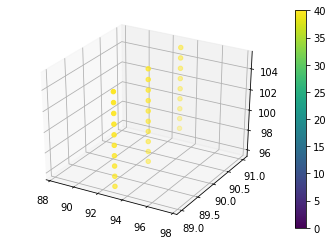

LABELS


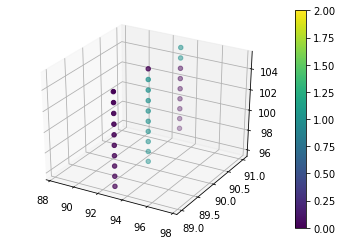

(array([0, 1]), array([7077877,      11]))
WEIGHTS


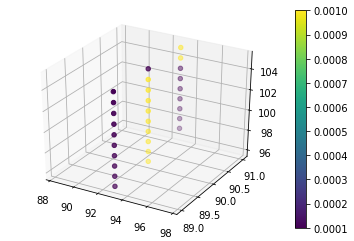

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


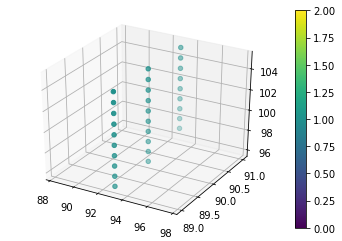

(array([0, 1]), array([7038801,   39087]))


  0%|          | 0/5 [00:00<?, ?it/s]

Saved weight: ./9-13_10img_weights_1x_provabisbisbis-0


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


ENERGY DEPOSITION


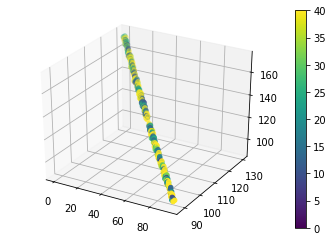

LABELS


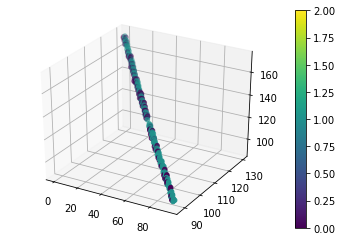

(array([0, 1]), array([7077717,     171]))
WEIGHTS


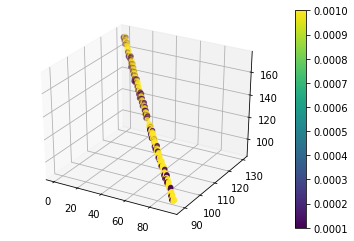

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


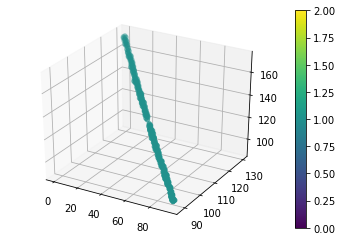

(array([0, 1]), array([7068376,    9512]))


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


ENERGY DEPOSITION


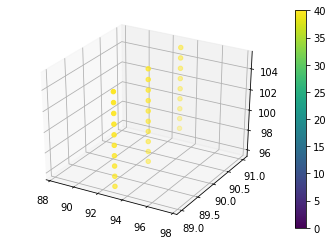

LABELS


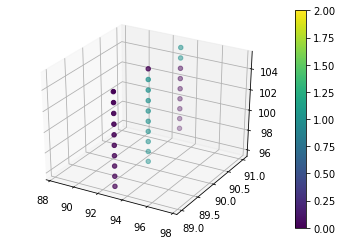

(array([0, 1]), array([7077877,      11]))
WEIGHTS


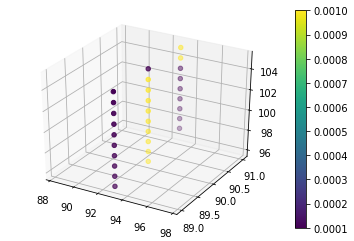

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


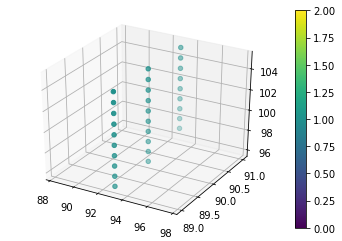

(array([0, 1]), array([7049112,   28776]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


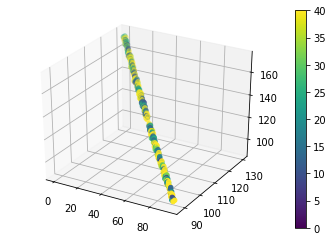

LABELS


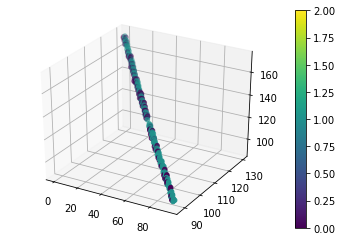

(array([0, 1]), array([7077717,     171]))
WEIGHTS


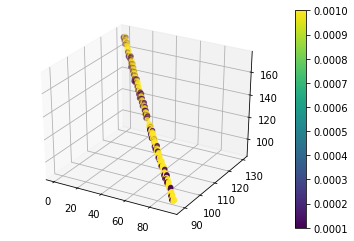

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


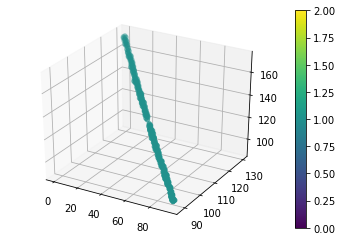

(array([0, 1]), array([7067368,   10520]))


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


ENERGY DEPOSITION


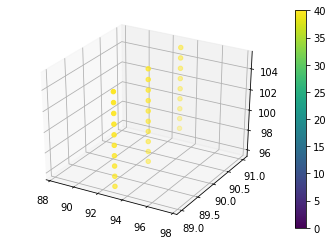

LABELS


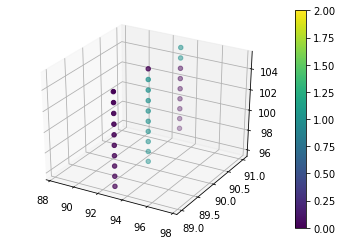

(array([0, 1]), array([7077877,      11]))
WEIGHTS


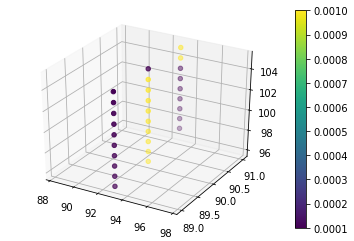

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


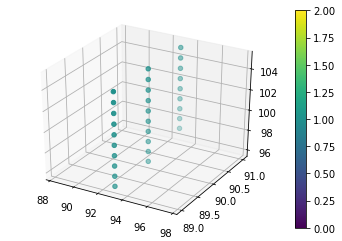

(array([0, 1]), array([7053318,   24570]))


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


ENERGY DEPOSITION


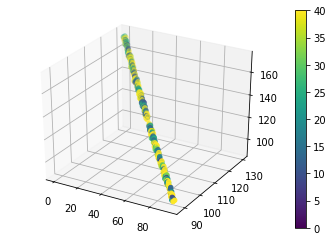

LABELS


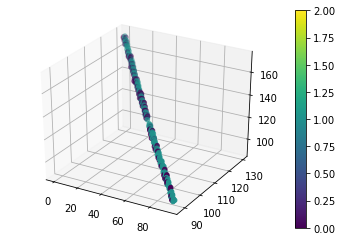

(array([0, 1]), array([7077717,     171]))
WEIGHTS


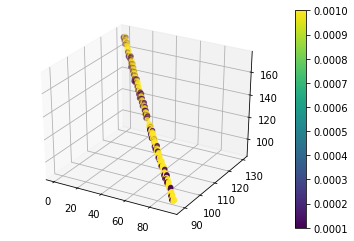

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


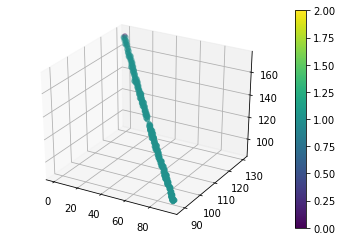

(array([0, 1]), array([7067092,   10796]))


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


ENERGY DEPOSITION


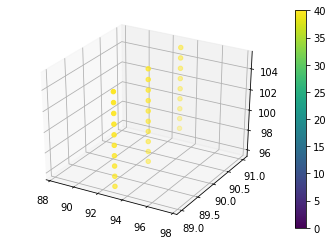

LABELS


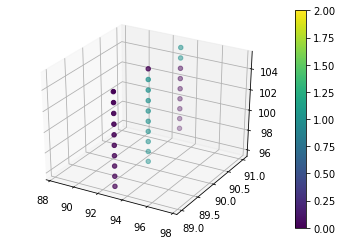

(array([0, 1]), array([7077877,      11]))
WEIGHTS


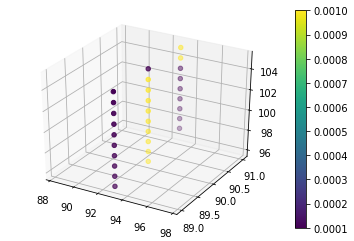

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


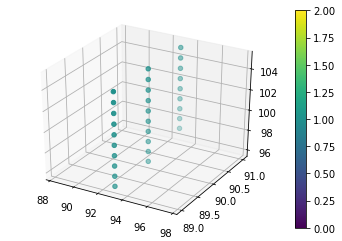

(array([0, 1]), array([7057714,   20174]))


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


ENERGY DEPOSITION


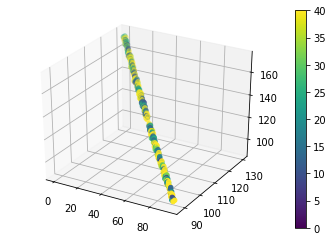

LABELS


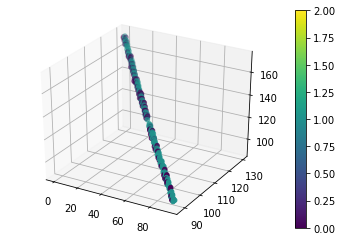

(array([0, 1]), array([7077717,     171]))
WEIGHTS


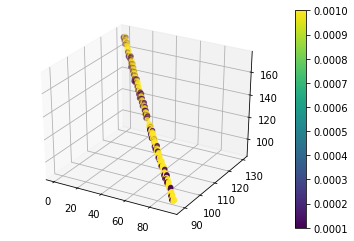

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


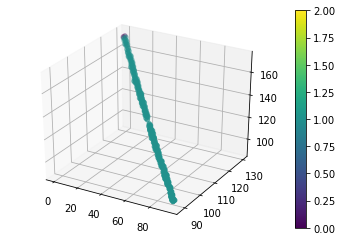

(array([0, 1]), array([7067141,   10747]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


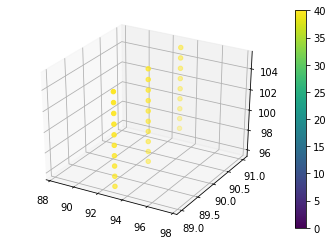

LABELS


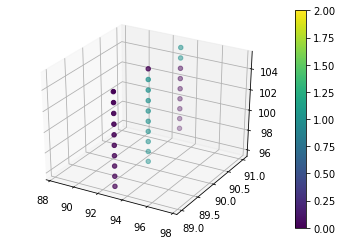

(array([0, 1]), array([7077877,      11]))
WEIGHTS


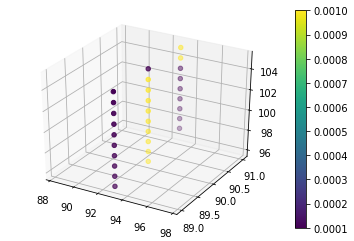

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


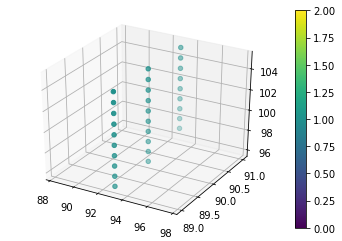

(array([0, 1]), array([7061508,   16380]))


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


ENERGY DEPOSITION


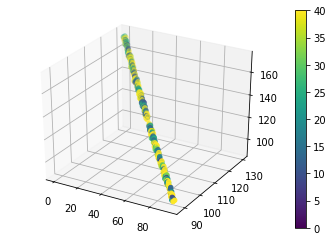

LABELS


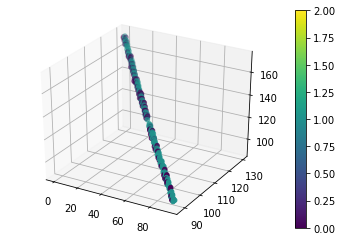

(array([0, 1]), array([7077717,     171]))
WEIGHTS


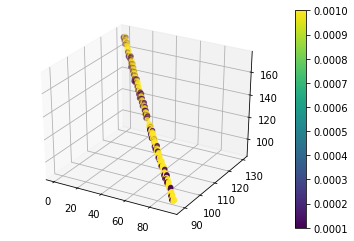

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


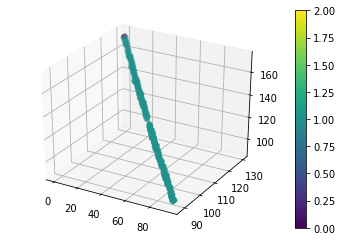

(array([0, 1]), array([7067062,   10826]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


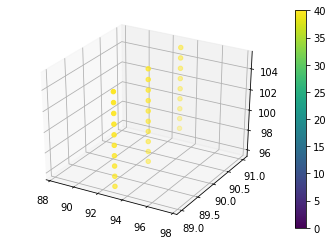

LABELS


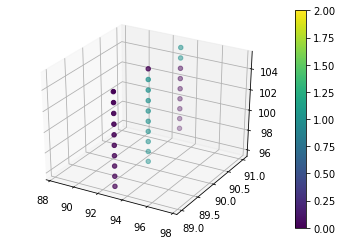

(array([0, 1]), array([7077877,      11]))
WEIGHTS


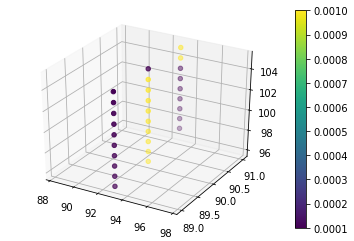

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


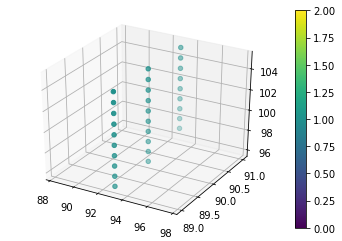

(array([0, 1]), array([7064364,   13524]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


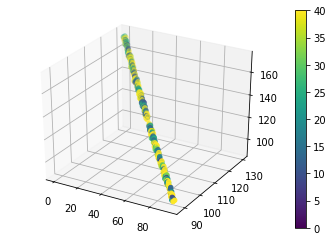

LABELS


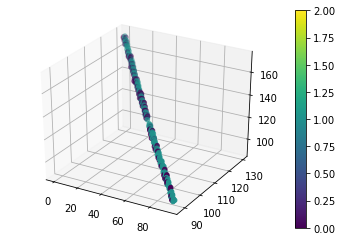

(array([0, 1]), array([7077717,     171]))
WEIGHTS


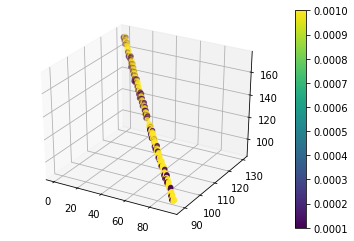

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


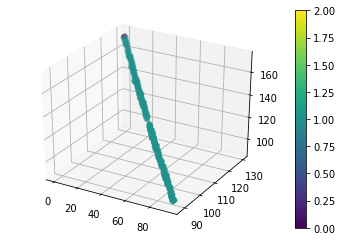

(array([0, 1]), array([7066951,   10937]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


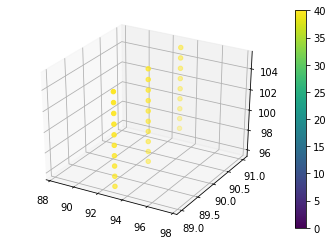

LABELS


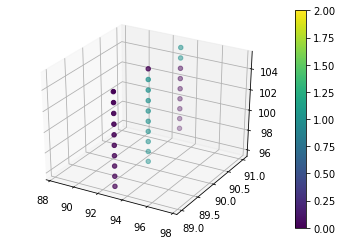

(array([0, 1]), array([7077877,      11]))
WEIGHTS


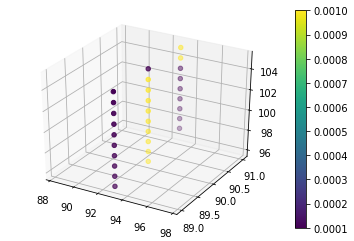

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


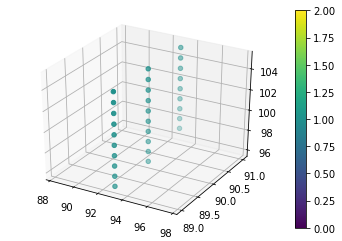

(array([0, 1]), array([7066212,   11676]))


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


ENERGY DEPOSITION


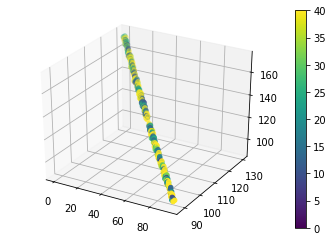

LABELS


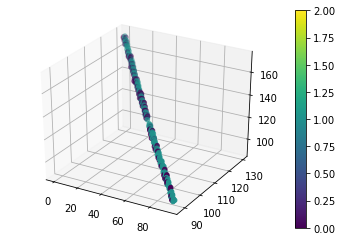

(array([0, 1]), array([7077717,     171]))
WEIGHTS


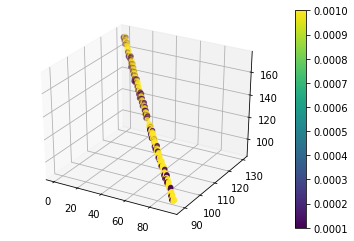

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


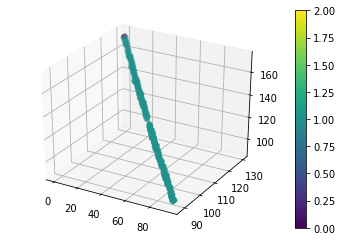

(array([0, 1]), array([7066274,   11614]))


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


ENERGY DEPOSITION


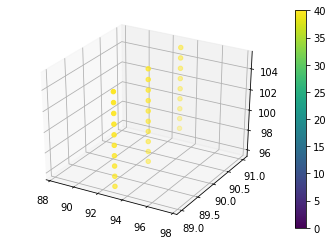

LABELS


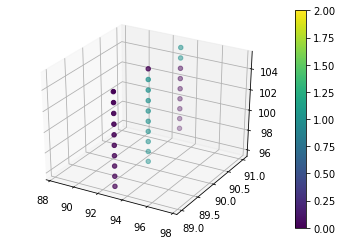

(array([0, 1]), array([7077877,      11]))
WEIGHTS


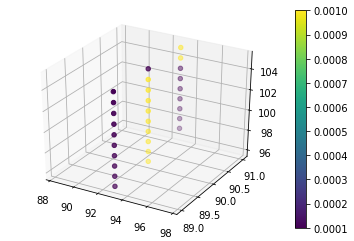

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


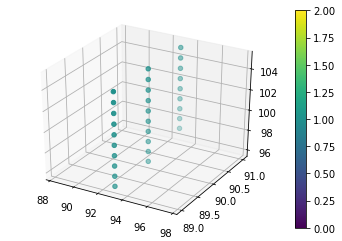

(array([0, 1]), array([7067187,   10701]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


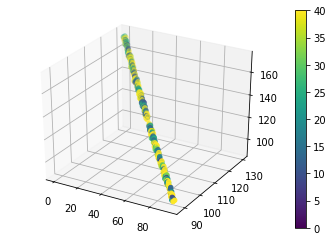

LABELS


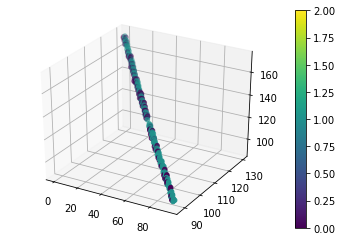

(array([0, 1]), array([7077717,     171]))
WEIGHTS


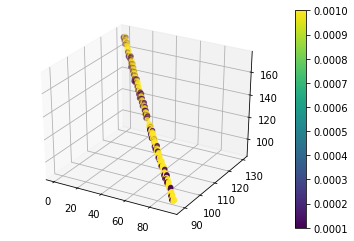

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


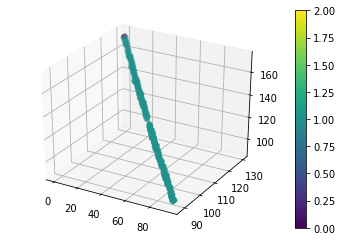

(array([0, 1]), array([7065054,   12834]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


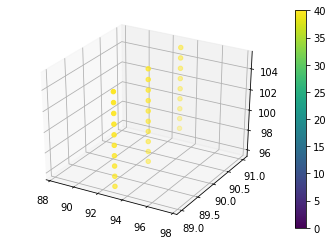

LABELS


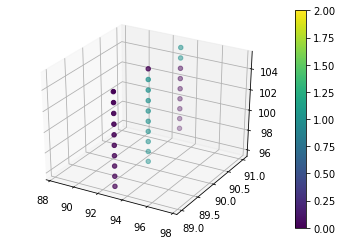

(array([0, 1]), array([7077877,      11]))
WEIGHTS


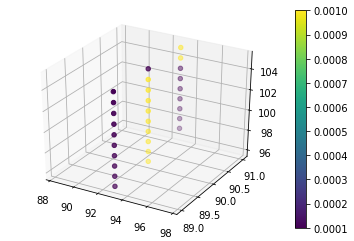

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


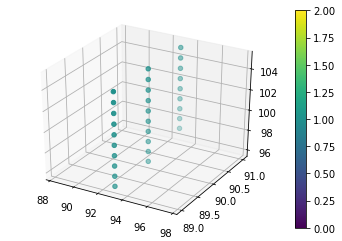

(array([0, 1]), array([7067689,   10199]))


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


ENERGY DEPOSITION


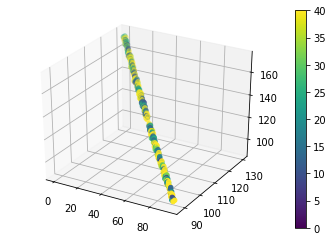

LABELS


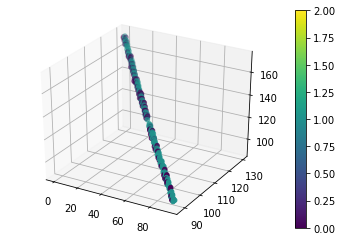

(array([0, 1]), array([7077717,     171]))
WEIGHTS


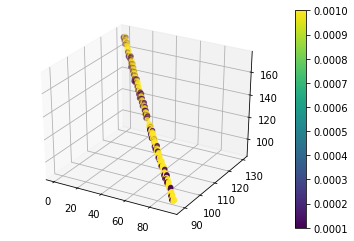

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


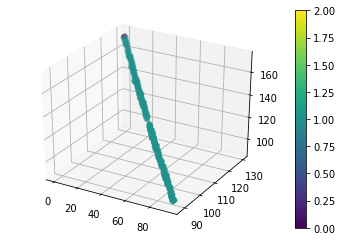

(array([0, 1]), array([7064079,   13809]))


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


ENERGY DEPOSITION


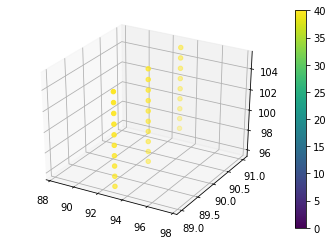

LABELS


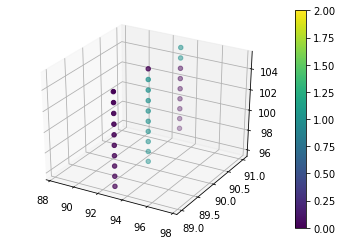

(array([0, 1]), array([7077877,      11]))
WEIGHTS


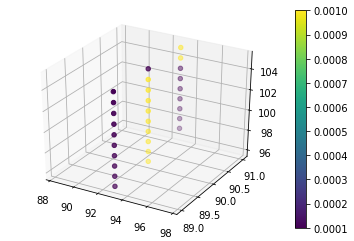

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


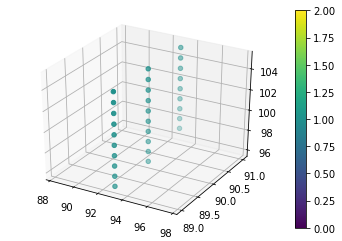

(array([0, 1]), array([7067856,   10032]))


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


ENERGY DEPOSITION


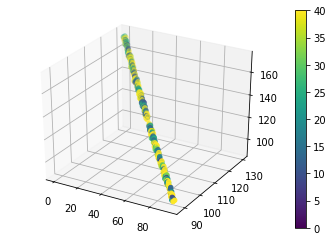

LABELS


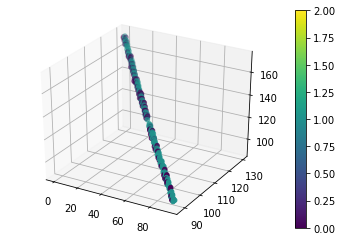

(array([0, 1]), array([7077717,     171]))
WEIGHTS


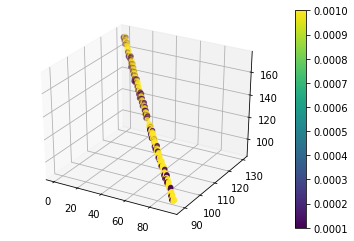

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


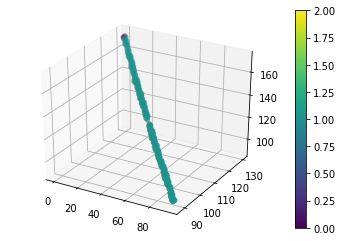

(array([0, 1]), array([7063309,   14579]))


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


ENERGY DEPOSITION


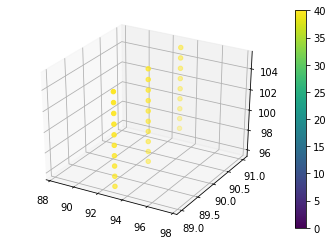

LABELS


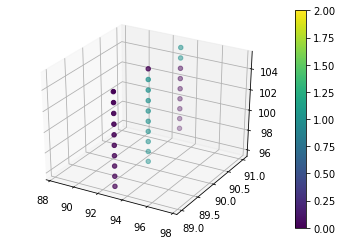

(array([0, 1]), array([7077877,      11]))
WEIGHTS


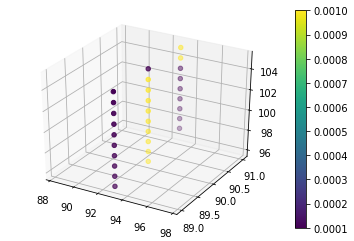

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


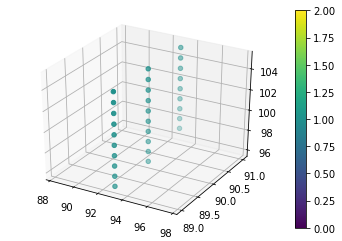

(array([0, 1]), array([7068227,    9661]))


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


ENERGY DEPOSITION


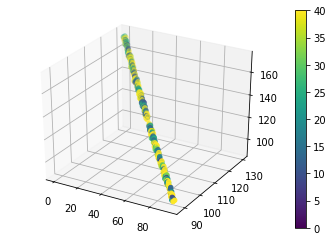

LABELS


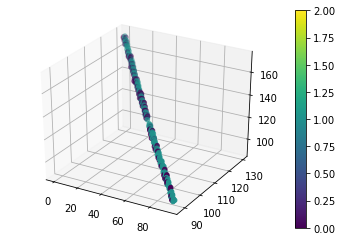

(array([0, 1]), array([7077717,     171]))
WEIGHTS


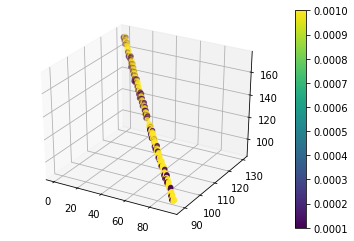

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


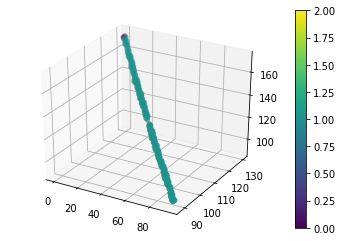

(array([0, 1]), array([7063219,   14669]))


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


ENERGY DEPOSITION


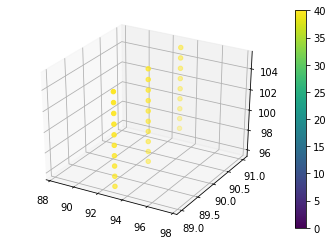

LABELS


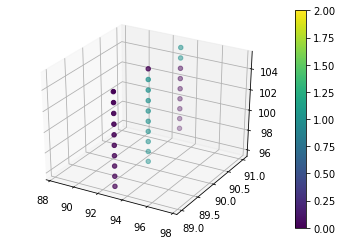

(array([0, 1]), array([7077877,      11]))
WEIGHTS


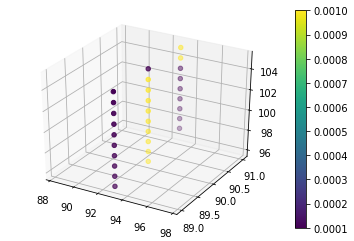

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


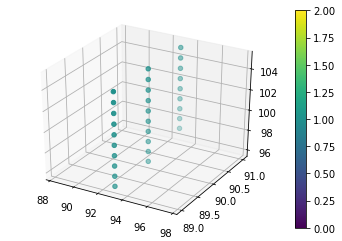

(array([0, 1]), array([7069000,    8888]))


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


ENERGY DEPOSITION


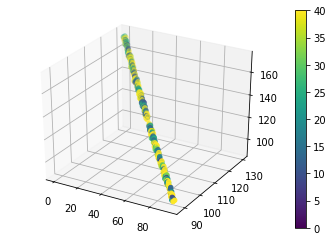

LABELS


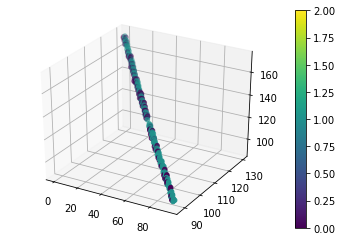

(array([0, 1]), array([7077717,     171]))
WEIGHTS


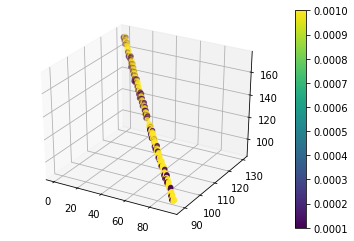

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


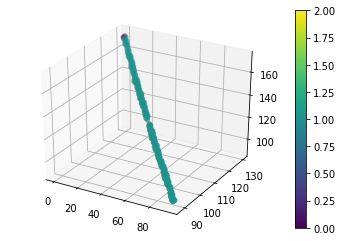

(array([0, 1]), array([7063500,   14388]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


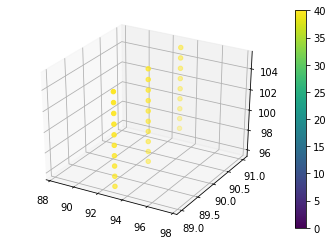

LABELS


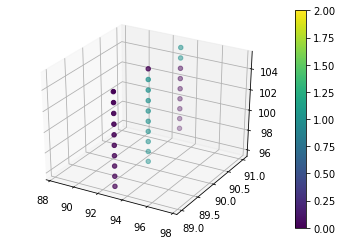

(array([0, 1]), array([7077877,      11]))
WEIGHTS


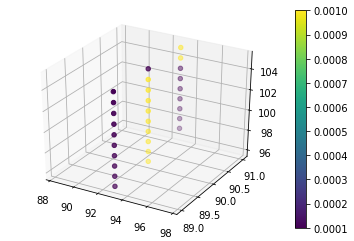

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


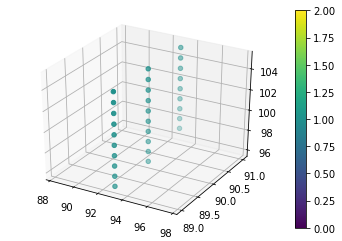

(array([0, 1]), array([7069969,    7919]))


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


ENERGY DEPOSITION


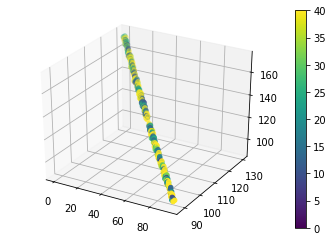

LABELS


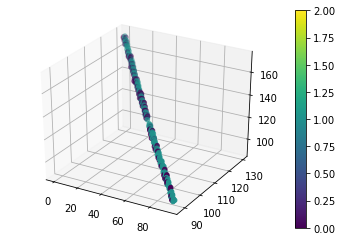

(array([0, 1]), array([7077717,     171]))
WEIGHTS


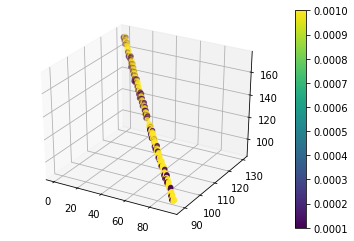

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


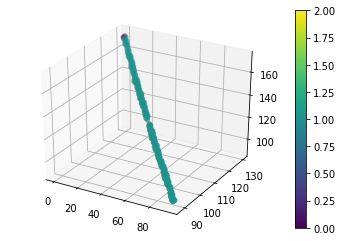

(array([0, 1]), array([7063908,   13980]))


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


ENERGY DEPOSITION


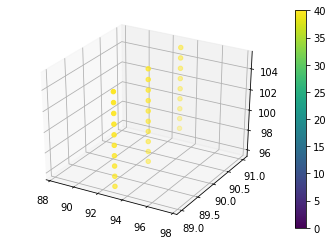

LABELS


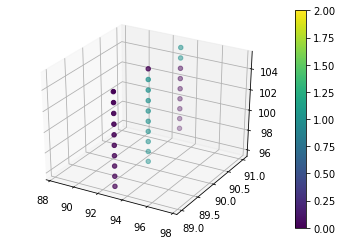

(array([0, 1]), array([7077877,      11]))
WEIGHTS


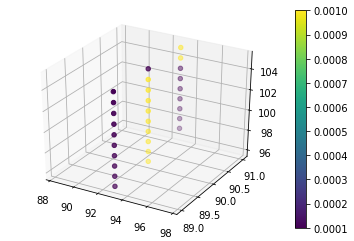

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


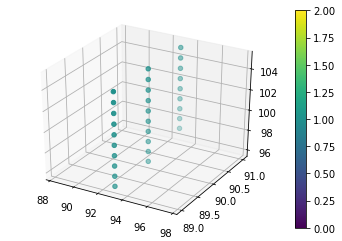

(array([0, 1]), array([7070785,    7103]))


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


ENERGY DEPOSITION


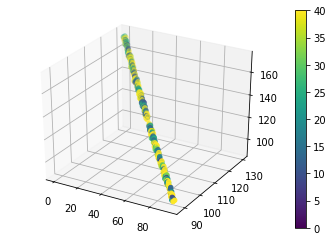

LABELS


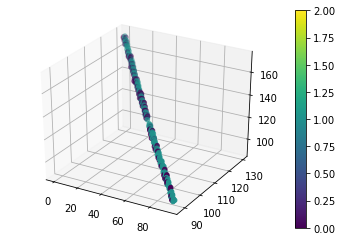

(array([0, 1]), array([7077717,     171]))
WEIGHTS


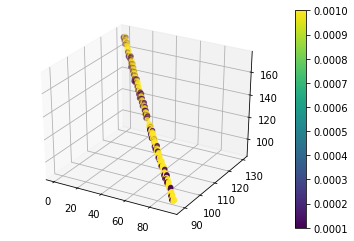

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


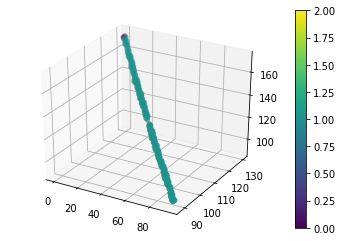

(array([0, 1]), array([7064055,   13833]))


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


ENERGY DEPOSITION


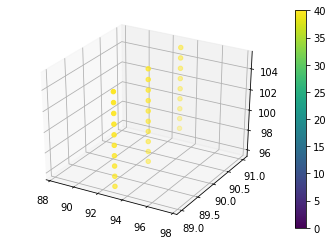

LABELS


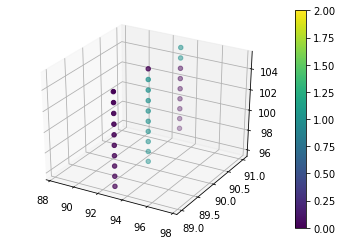

(array([0, 1]), array([7077877,      11]))
WEIGHTS


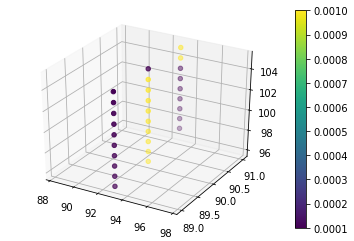

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


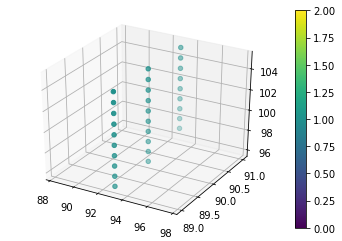

(array([0, 1]), array([7071341,    6547]))


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


ENERGY DEPOSITION


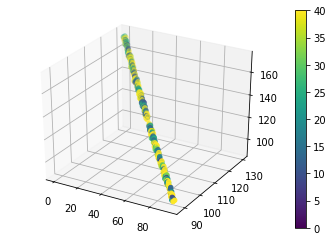

LABELS


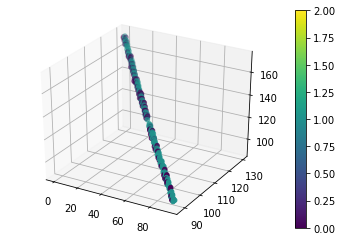

(array([0, 1]), array([7077717,     171]))
WEIGHTS


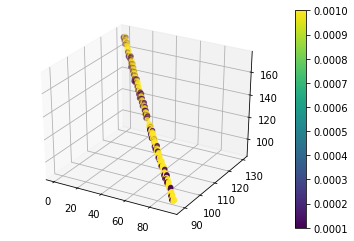

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


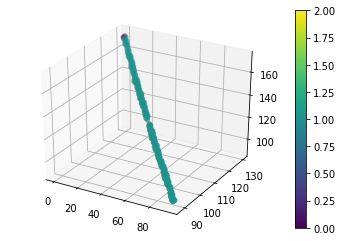

(array([0, 1]), array([7064171,   13717]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


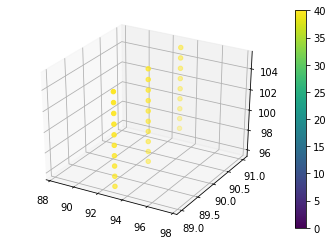

LABELS


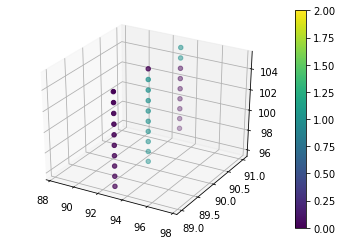

(array([0, 1]), array([7077877,      11]))
WEIGHTS


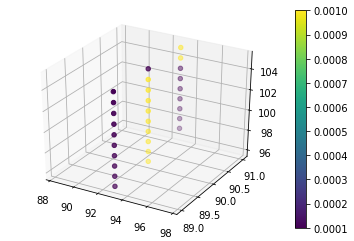

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


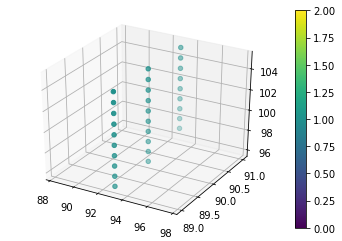

(array([0, 1]), array([7071791,    6097]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


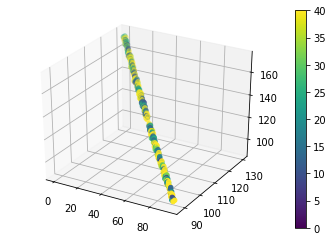

LABELS


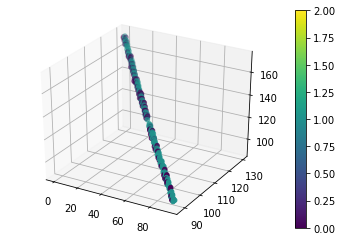

(array([0, 1]), array([7077717,     171]))
WEIGHTS


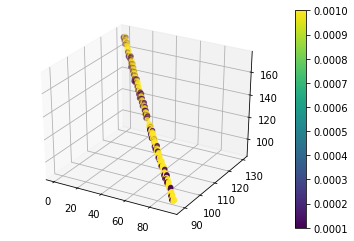

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


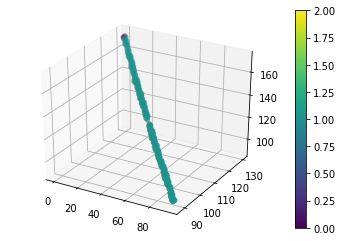

(array([0, 1]), array([7064353,   13535]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


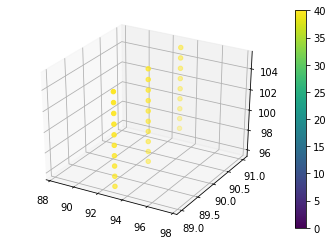

LABELS


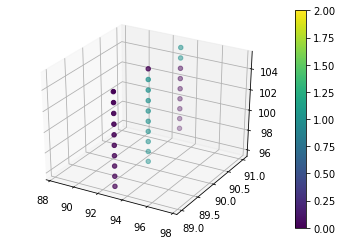

(array([0, 1]), array([7077877,      11]))
WEIGHTS


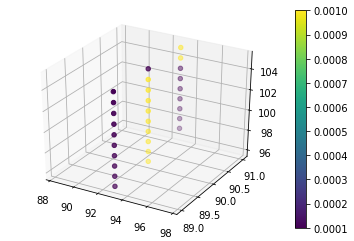

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


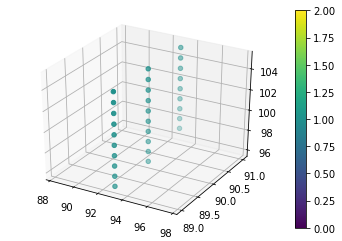

(array([0, 1]), array([7072085,    5803]))


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


ENERGY DEPOSITION


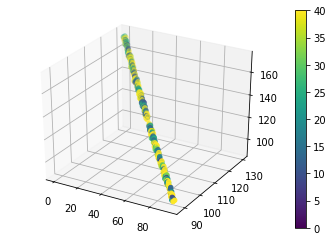

LABELS


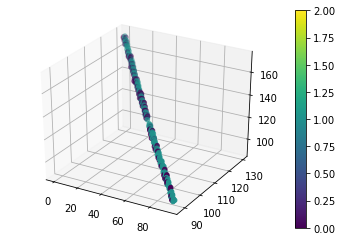

(array([0, 1]), array([7077717,     171]))
WEIGHTS


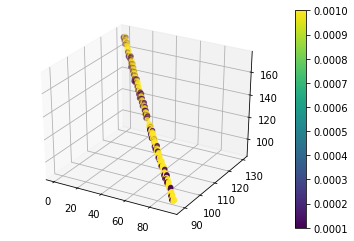

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


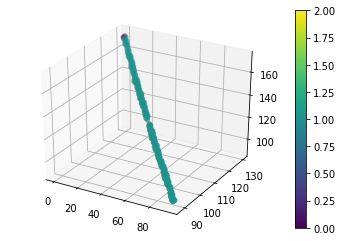

(array([0, 1]), array([7064527,   13361]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


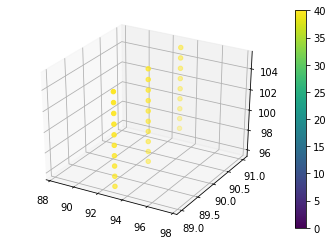

LABELS


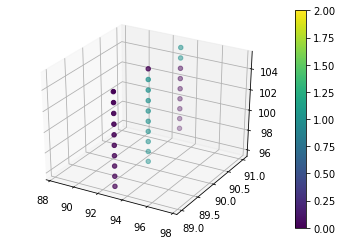

(array([0, 1]), array([7077877,      11]))
WEIGHTS


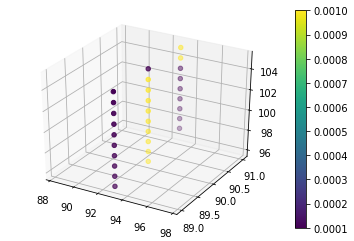

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


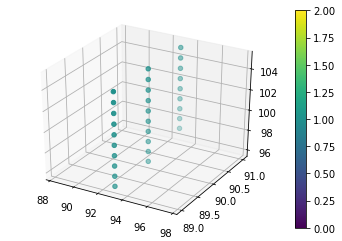

(array([0, 1]), array([7072303,    5585]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


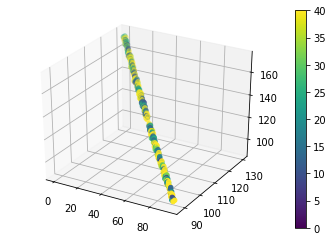

LABELS


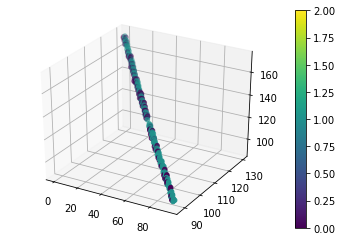

(array([0, 1]), array([7077717,     171]))
WEIGHTS


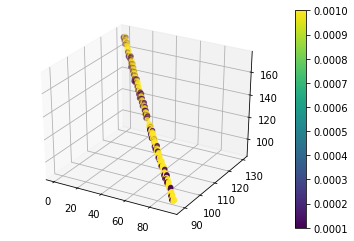

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


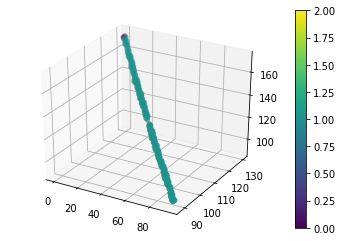

(array([0, 1]), array([7064717,   13171]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


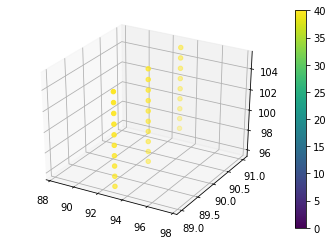

LABELS


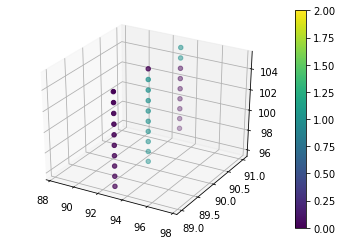

(array([0, 1]), array([7077877,      11]))
WEIGHTS


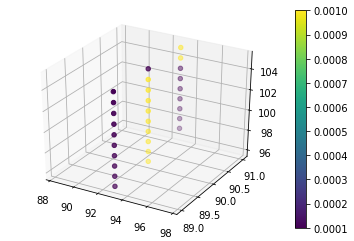

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


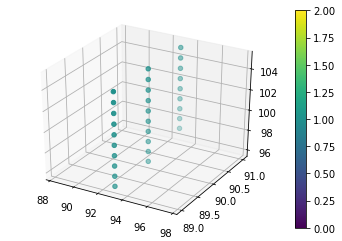

(array([0, 1]), array([7072510,    5378]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


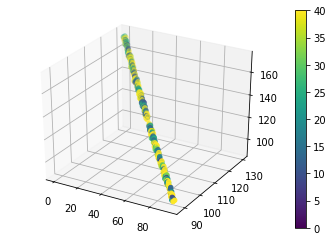

LABELS


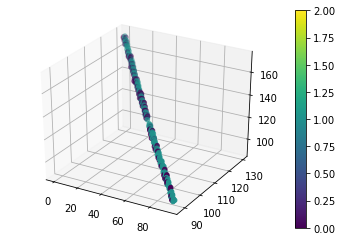

(array([0, 1]), array([7077717,     171]))
WEIGHTS


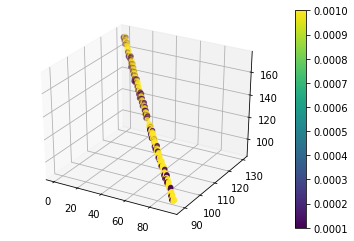

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


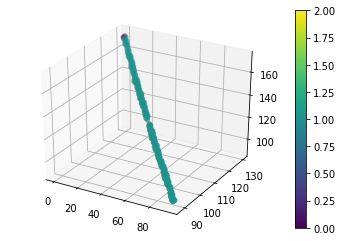

(array([0, 1]), array([7064961,   12927]))


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


ENERGY DEPOSITION


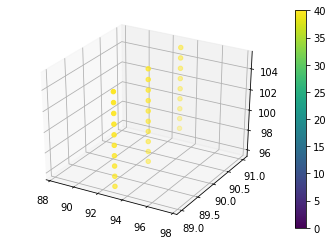

LABELS


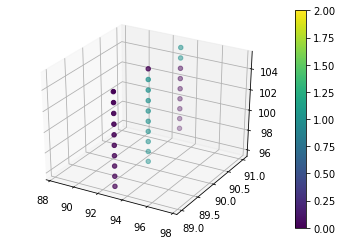

(array([0, 1]), array([7077877,      11]))
WEIGHTS


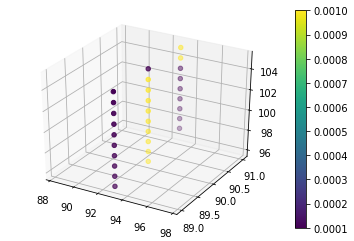

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


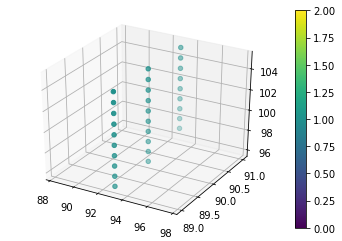

(array([0, 1]), array([7072660,    5228]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


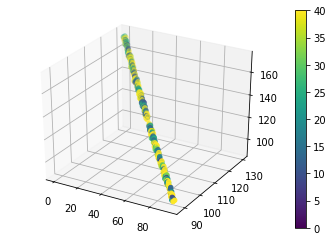

LABELS


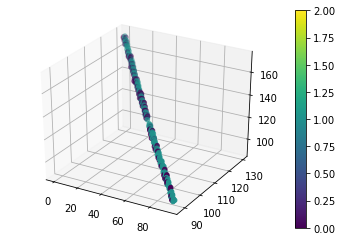

(array([0, 1]), array([7077717,     171]))
WEIGHTS


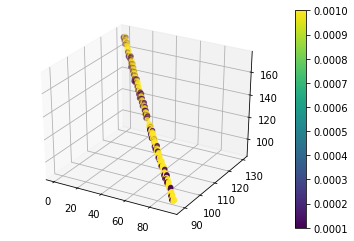

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


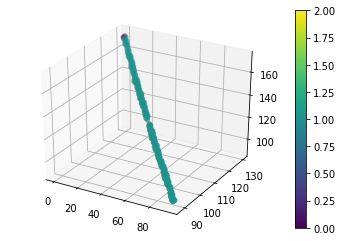

(array([0, 1]), array([7065145,   12743]))


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


ENERGY DEPOSITION


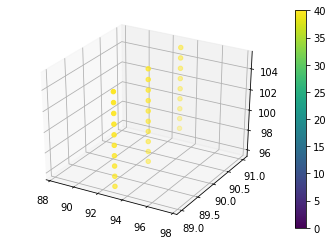

LABELS


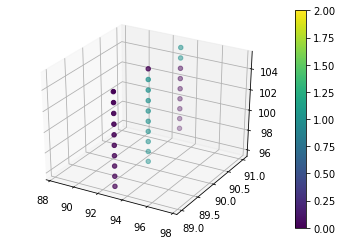

(array([0, 1]), array([7077877,      11]))
WEIGHTS


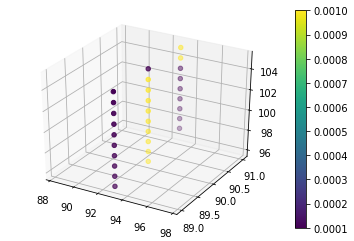

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


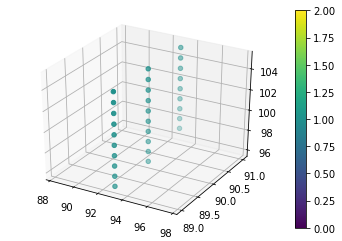

(array([0, 1]), array([7072811,    5077]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


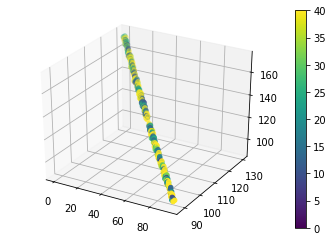

LABELS


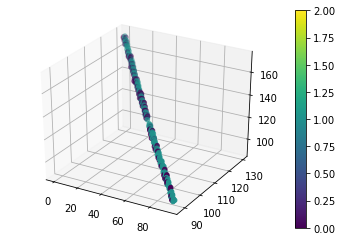

(array([0, 1]), array([7077717,     171]))
WEIGHTS


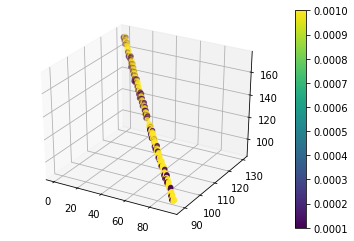

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


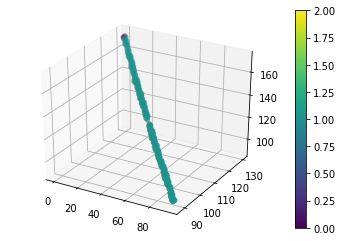

(array([0, 1]), array([7065329,   12559]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


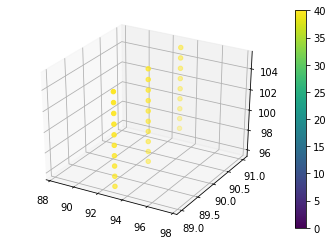

LABELS


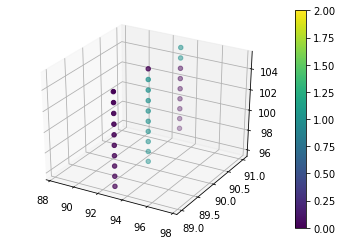

(array([0, 1]), array([7077877,      11]))
WEIGHTS


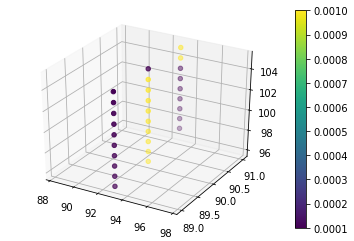

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


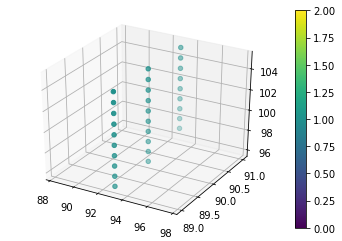

(array([0, 1]), array([7072949,    4939]))


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


ENERGY DEPOSITION


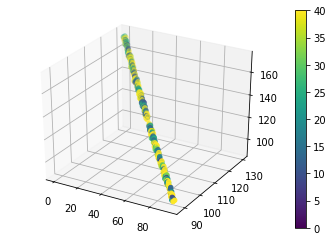

LABELS


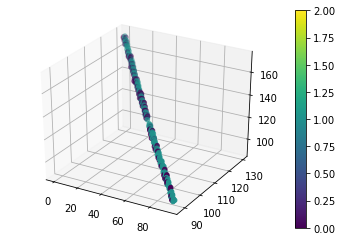

(array([0, 1]), array([7077717,     171]))
WEIGHTS


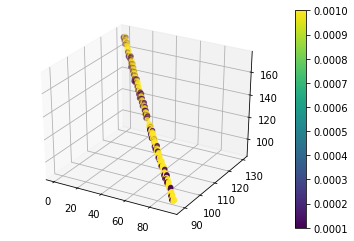

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


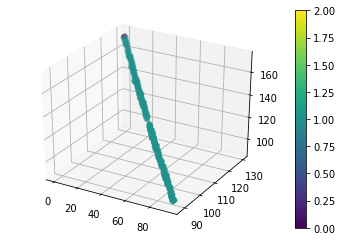

(array([0, 1]), array([7065499,   12389]))


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


ENERGY DEPOSITION


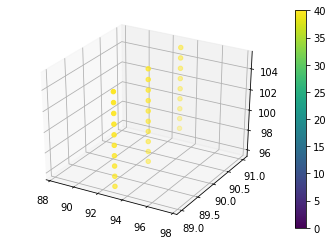

LABELS


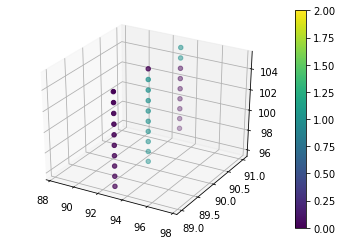

(array([0, 1]), array([7077877,      11]))
WEIGHTS


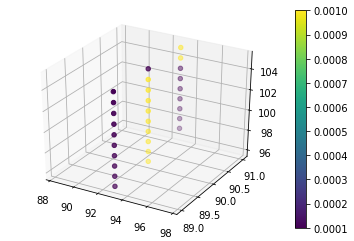

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


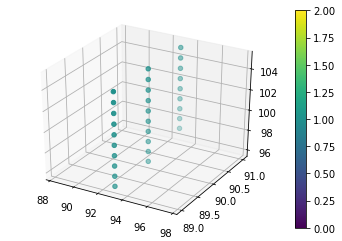

(array([0, 1]), array([7073061,    4827]))


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


ENERGY DEPOSITION


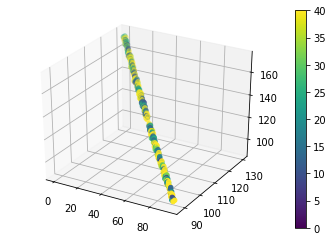

LABELS


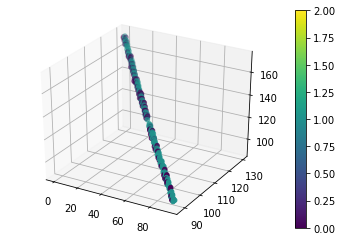

(array([0, 1]), array([7077717,     171]))
WEIGHTS


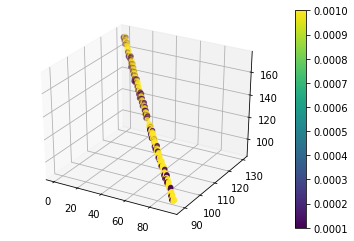

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


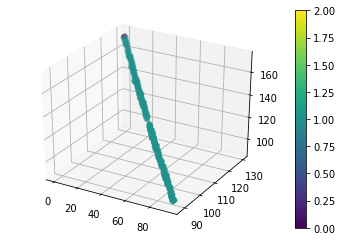

(array([0, 1]), array([7065675,   12213]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


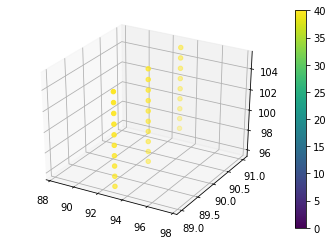

LABELS


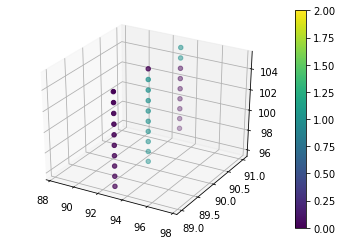

(array([0, 1]), array([7077877,      11]))
WEIGHTS


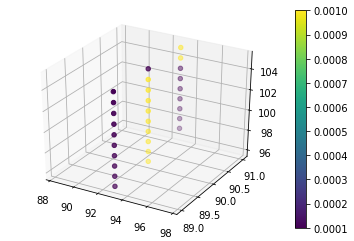

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


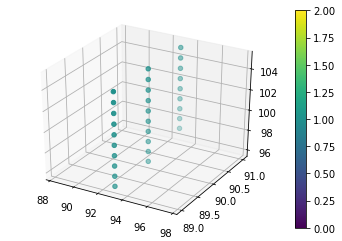

(array([0, 1]), array([7073166,    4722]))


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


ENERGY DEPOSITION


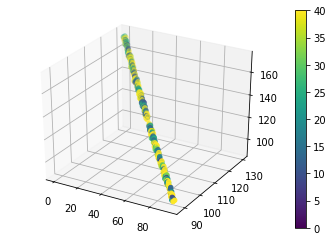

LABELS


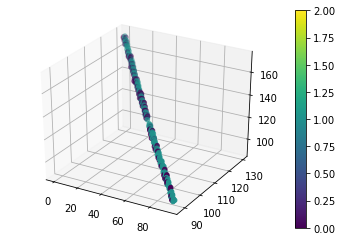

(array([0, 1]), array([7077717,     171]))
WEIGHTS


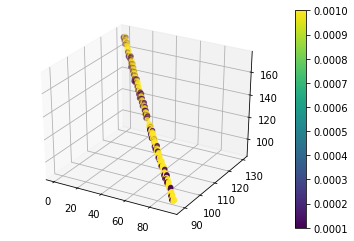

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


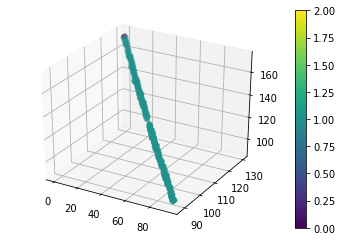

(array([0, 1]), array([7065793,   12095]))


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


ENERGY DEPOSITION


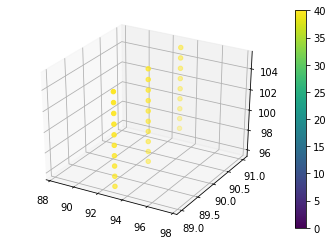

LABELS


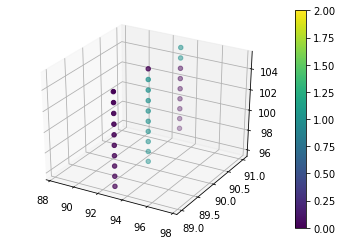

(array([0, 1]), array([7077877,      11]))
WEIGHTS


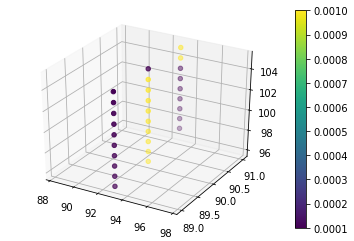

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


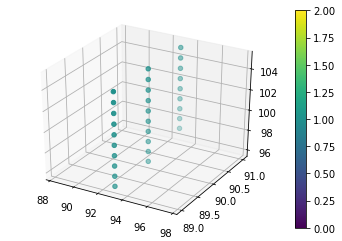

(array([0, 1]), array([7073271,    4617]))


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


ENERGY DEPOSITION


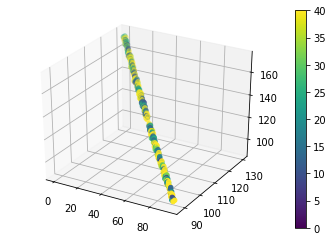

LABELS


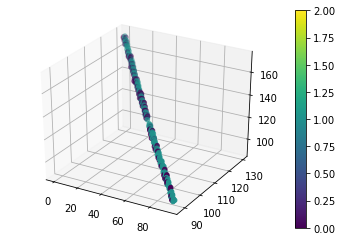

(array([0, 1]), array([7077717,     171]))
WEIGHTS


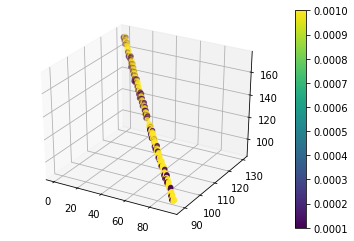

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


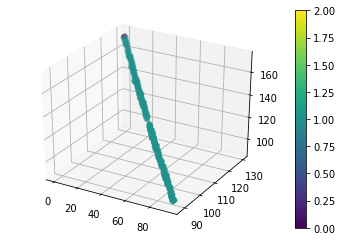

(array([0, 1]), array([7065960,   11928]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


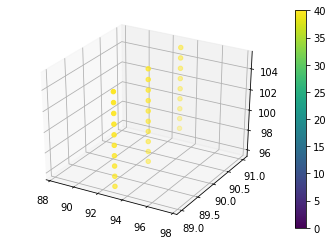

LABELS


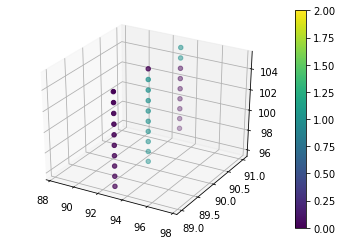

(array([0, 1]), array([7077877,      11]))
WEIGHTS


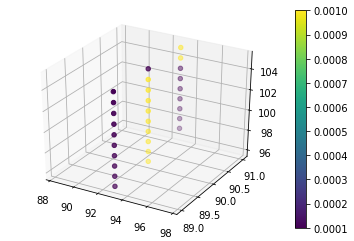

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


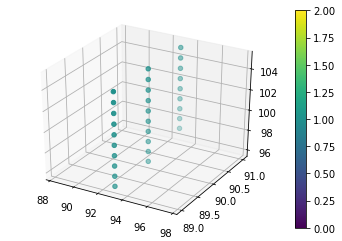

(array([0, 1]), array([7073349,    4539]))


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


ENERGY DEPOSITION


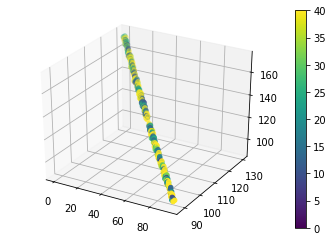

LABELS


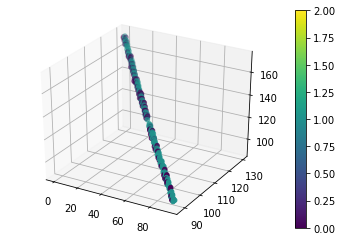

(array([0, 1]), array([7077717,     171]))
WEIGHTS


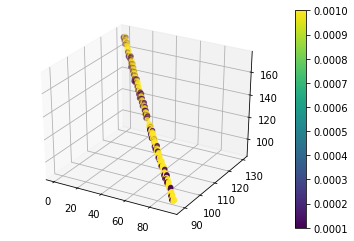

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


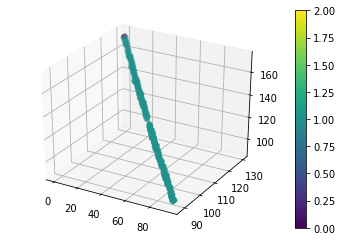

(array([0, 1]), array([7066171,   11717]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


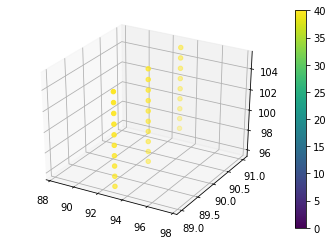

LABELS


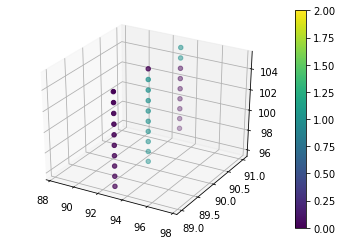

(array([0, 1]), array([7077877,      11]))
WEIGHTS


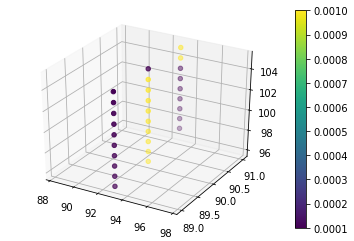

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


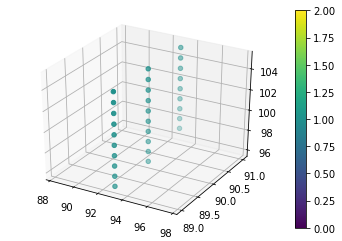

(array([0, 1]), array([7073452,    4436]))


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


ENERGY DEPOSITION


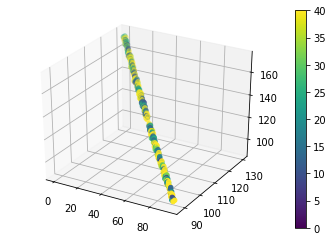

LABELS


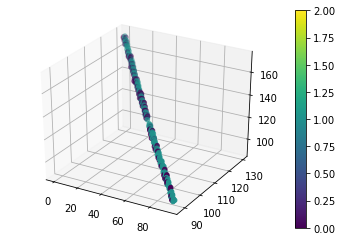

(array([0, 1]), array([7077717,     171]))
WEIGHTS


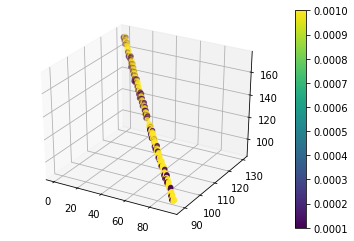

(array([7.0644248e-08, 2.9239766e-03], dtype=float32), array([7077717,     171]))
PREDICTION


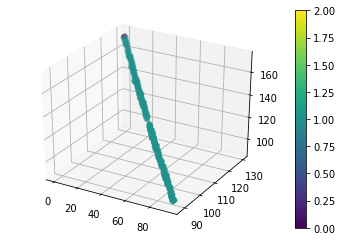

(array([0, 1]), array([7066404,   11484]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


ENERGY DEPOSITION


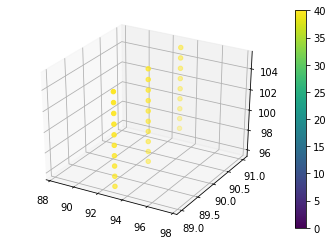

LABELS


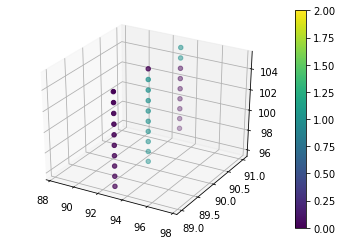

(array([0, 1]), array([7077877,      11]))
WEIGHTS


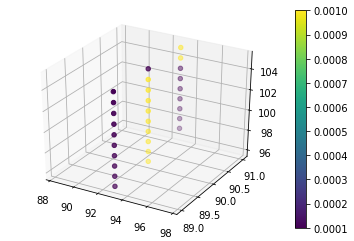

(array([7.0642649e-08, 4.5454547e-02], dtype=float32), array([7077877,      11]))
PREDICTION


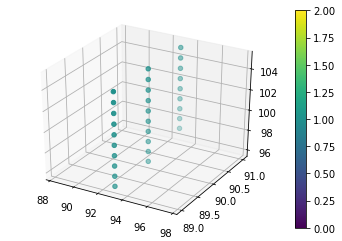

(array([0, 1]), array([7073532,    4356]))


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


In [ ]:
train_loop(40000,lr=0.1)

In [ ]:
#plot_log(log)

In [ ]:
print('Saved weight: {:s}'.format(saver.save(sess, './9-13_10img_weights_1x_provabisbisbis', global_step=30000)))

#with open('training_variables_all_9-04_zero.csv', mode='w') as employee_file:
 #   file_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  #  for i in range(30000):
   #     file_writer.writerow([log.train_loss[i], log.acc_all[i], log.acc_val[i]])

In [ ]:
import commands
print(commands.getoutput('nvidia-smi'))

In [ ]:
f.close()